In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchnlp.datasets import imdb_dataset
from torchnlp.datasets import penn_treebank_dataset
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1
MASKED_token = 2
MAX_LENGTH = 42

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOSTOKEN": 0, "EOSTOKEN": 1, "MASKEDTOKEN": 2}
        self.index2word = {0: "SOSTOKEN", 1: "EOSTOKEN", 2: "MASKEDTOKEN"}
        self.word2count = {"SOSTOKEN": 0, "EOSTOKEN": 0, "MASKEDTOKEN": 0}
        
        self.n_words = 3  # Count SOS and EOS and Masked token

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def unicodeToAscii(s):
    """
    Turn a Unicode string to plain ASCII, thanks to
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):  # Lowercase, trim, and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = " ".join(s.split()[:40])
    return s

In [4]:
def readLang(dataset_title):
    """
    Args:
        dataset_title: either 'imdb' or 'ptb'
    """
    print("Reading lines...")
    if dataset_title == 'imdb':
        train = imdb_dataset(train=True, directory='../data/')
        # Read the dataset and split into lines
        lines = [train[ind]['text'].strip() for ind, doc in enumerate(train)]
        # Normalize lines
        lines = [' '.join(["SOSTOKEN", normalizeString(s), "EOSTOKEN"]) for s in lines]
        lang = Lang(dataset_title)
    elif dataset_title == 'ptb':
        raise NotImplementedError
    return lang, lines

In [5]:
def prepareData(dataset_title):
    lang, lines = readLang(dataset_title)
    print("Read %s sentence pairs" % len(lines))
    print("Counting words...")
    for l in lines:
        lang.addSentence(l)
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, lines

In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsForTrain(lang, sentence):
    # mask = generate_mask(len(sentence))
    target_tensor = tensorFromSentence(lang, sentence)
    # transformed_sentence = " ".join(transform_input_with_is_missing_token(sentence.split(), mask))
    #input_tensor = tensorFromSentence(lang, transformed_sentence)
    return target_tensor # , target_tensor

def indexFromTensor(lang, decoder_output):
    return decoder_output.max(0)[1]

In [7]:
class pretrainLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        output = self.fc(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [8]:
MAX_LENGTH = 42 # max(map(lambda x: len(x.split()), imdb_lines)) == 2516

def train(input_tensor, model, model_optimizer, criterion, max_length=MAX_LENGTH):
    model_hidden = model.initHidden()

    model_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    
    model_outputs = torch.zeros(max_length, model.input_size, device=device)

    loss = 0

    for ei in range(input_length - 1):
        model_output, model_hidden = model(
            input_tensor[ei], model_hidden)
        #print(model_output, input_tensor.shape, input_tensor[0].shape)
        loss += criterion(model_output[0], input_tensor[ei + 1])
        model_outputs[ei] = model_output[0]
    
    loss.backward()

    
    model_optimizer.step()

    return loss.item() / input_length

In [9]:
from time import time

In [10]:
def trainIters(model, lang, lines, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    #start = time.time()
    start = time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    model_optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    training_sentences = [tensorFromSentence(lang, lines[0]) for i in range(n_iters)]
    
    criterion = nn.CrossEntropyLoss() 
    
    for number in range(1, n_iters + 1):
        #c_ = time()
        input_tensor = training_sentences[number - 1]
        #print('Pairs created ...', time() - c_)
        #c_ = time()
        loss = train(input_tensor, model,
                     model_optimizer, criterion)
        #print('Loss is done...', time() - c_)
        #c_ = time()
        print_loss_total += loss
        plot_loss_total += loss

        if number % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, number / n_iters),
                                         number, number / n_iters * 100, print_loss_avg))

        if number % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    
    showPlot(plot_losses)
    return plot_losses

In [11]:
from time import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [12]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    #print(points)
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.grid()
    plt.show();
    print('plot was shown')

In [13]:
imdb_lines[0]

NameError: name 'imdb_lines' is not defined

In [14]:
%%time
imdb_lang, imdb_lines = prepareData('imdb')
#print(random.choice(imdb_lines))

Reading lines...
Read 25000 sentence pairs
Counting words...
Counted words:
imdb 32736
CPU times: user 11 s, sys: 230 ms, total: 11.2 s
Wall time: 11.2 s


In [52]:
hidden_size = 64
lstm = pretrainLSTM(imdb_lang.n_words, hidden_size).to(device)

0m 8s (- 1m 16s) (10 10%) 9.3388
0m 16s (- 1m 7s) (20 20%) 8.3978
0m 25s (- 0m 59s) (30 30%) 6.0432
0m 34s (- 0m 51s) (40 40%) 2.8214
0m 44s (- 0m 44s) (50 50%) 1.2673
0m 53s (- 0m 35s) (60 60%) 0.7675
1m 4s (- 0m 27s) (70 70%) 0.5228
1m 16s (- 0m 19s) (80 80%) 0.3770
1m 26s (- 0m 9s) (90 90%) 0.2857
1m 36s (- 0m 0s) (100 100%) 0.2256


<Figure size 432x288 with 0 Axes>

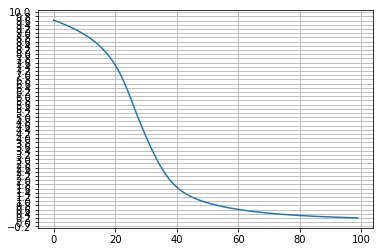

plot was shown
Wall time: 1min 36s


In [60]:
%%time
trainIters(lstm, imdb_lang, imdb_lines, 100, print_every=10, plot_every=1)

In [15]:
result = dict()

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
numbers = [2 ** i for i in range(5, 10)]
for hidden_size in numbers:
    #hidden_size = 64
    print(hidden_size)
    lstm = pretrainLSTM(imdb_lang.n_words, hidden_size).to(device)
    result[hidden_size] = trainIters(lstm, imdb_lang, imdb_lines, 1000, print_every=100, plot_every=1)
    clear_output()

256
0m 58s (- 8m 48s) (100 10%) 1.8451
1m 57s (- 7m 49s) (200 20%) 0.0191
2m 56s (- 6m 51s) (300 30%) 0.0094
3m 55s (- 5m 52s) (400 40%) 0.0061
4m 53s (- 4m 53s) (500 50%) 0.0045
5m 52s (- 3m 54s) (600 60%) 0.0036
6m 52s (- 2m 56s) (700 70%) 0.0029


In [25]:
result.keys()

dict_keys([32, 64, 128, 256, 512])

In [33]:
import pickle as pkl
pkl.dump(result, open('losses.pkl', 'wb'))

In [26]:
new_res = []
number = []
for key in result.keys():
    new_res.append(result[key][-1])
    number.append(key)
    print(key, result[key][-1])

32 0.017981847127278645
64 0.0068881625220889135
128 0.0032731464930943082
256 0.0017632983979724702
512 0.001079922630673363


In [38]:
import numpy as np

In [40]:
number[np.argmin(new_res)]

1024

In [11]:
showPlot(result[512][50:200])

NameError: name 'showPlot' is not defined